# Goodbooks-10k — Data Preprocessing (Colab)
**Goal:** Clean, join, and featurize Goodbooks-10k for downstream modeling.  
**Notes:** Paths point to Google Drive as used during development.

# Preprocessing

## setup & Environment

### Imports & Versions

In [1]:
import os, sys, math, json, random, time, re, gc
from pathlib import Path
import numpy as np
import pandas as pd

# Display + warnings
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.width", 120)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Version stamp (helps reviewers)
def _versions():
    return {
        "python": sys.version.split()[0],
        "pandas": pd.__version__,
        "numpy": np.__version__,
    }
print("ENV:", _versions())


ENV: {'python': '3.12.11', 'pandas': '2.2.2', 'numpy': '2.0.2'}


### Config

In [2]:
from google.colab import drive, files
import os, glob, pprint

drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/BRS"
BOOKS_CSV = f"{DATA_DIR}/books.csv"
RATINGS_CSV = f"{DATA_DIR}/ratings.csv"
TAGS_CSV = f"{DATA_DIR}/tags.csv"
BOOK_TAGS_CSV = f"{DATA_DIR}/book_tags.csv"

# Quick existence checks (cheap sanity)
for p in [BOOKS_CSV, RATINGS_CSV, TAGS_CSV, BOOK_TAGS_CSV]:
    if not os.path.exists(p):
        print(f"⚠️ Missing: {p} (will skip check during repo review)")
    else:
        print(f"✅ Exists: {p}")


Mounted at /content/drive
✅ Exists: /content/drive/MyDrive/BRS/books.csv
✅ Exists: /content/drive/MyDrive/BRS/ratings.csv
✅ Exists: /content/drive/MyDrive/BRS/tags.csv
✅ Exists: /content/drive/MyDrive/BRS/book_tags.csv


In [3]:
print("Files under DATA_DIR (top-level + 2-levels):\n")
for f in sorted(glob.glob(os.path.join(DATA_DIR, '**', '*.csv'), recursive=True)):
    print(" -", os.path.relpath(f, DATA_DIR))


Files under DATA_DIR (top-level + 2-levels):

 - book_tags.csv
 - books.csv
 - preprocessed/book_index.csv
 - preprocessed/books_clean.csv
 - preprocessed/ratings_clean.csv
 - preprocessed/tag_vocab.csv
 - preprocessed/to_read_clean.csv
 - ratings.csv
 - samples/book_tags.csv
 - samples/books.csv
 - samples/ratings.csv
 - samples/tags.csv
 - samples/to_read.csv
 - tags.csv
 - to_read.csv


## Data Loading
We load the full Goodbooks-10k CSV files from Drive, applying `dtypes` for efficiency.  
Each dataframe is previewed with its shape and first few rows.

In [4]:
# File names
FILES = {
    "books": "books.csv",
    "ratings": "ratings.csv",
    "to_read": "to_read.csv",
    "tags": "tags.csv",
    "book_tags": "book_tags.csv",
}

# Explicit dtypes for memory efficiency
DTYPES = {
    "ratings":    {"user_id": np.int64, "book_id": np.int64, "rating": np.int8},
    "to_read":    {"user_id": np.int64, "book_id": np.int64},
    "tags":       {"tag_id": np.int32, "tag_name": "string"},
    "book_tags":  {"goodreads_book_id": np.int64, "tag_id": np.int32, "count": np.int32},
}

# Load all dataframes
dfs = {}
for key, fname in FILES.items():
    path = os.path.join(DATA_DIR, fname)
    print(f"Loading {fname} ...", end=" ")
    df = pd.read_csv(path, dtype=DTYPES.get(key), low_memory=False)
    dfs[key] = df
    print(f"shape={df.shape}")
    display(df.head(3))


Loading books.csv ... shape=(10000, 23)


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg


Loading ratings.csv ... shape=(5976479, 3)


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5


Loading to_read.csv ... shape=(912705, 2)


,user_id,book_id
0,9,8
1,15,398
2,15,275


Loading tags.csv ... shape=(34252, 2)


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-


Loading book_tags.csv ... shape=(999912, 3)


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173


### Quick Summary
We summarize each dataframe with basic stats: row/column counts and total number of nulls.

In [5]:
summary = {
    name: {
        "rows": len(df),
        "cols": df.shape[1],
        "nulls": int(df.isna().sum().sum()),
    }
    for name, df in dfs.items()
}

pd.DataFrame(summary).T


,rows,cols,nulls
books,10000,23,2975
ratings,5976479,3,0
to_read,912705,2,0
tags,34252,2,0
book_tags,999912,3,0


## Data Understanding & Cleaning
We review each file and decide which columns to keep or drop.  
Notes are summarized here (taken from the initial dataset exploration):

- **books.csv**
  - Keep: `book_id` (main key), `original_title` (preferred title), `average_rating`, `work_ratings_count`, `work_text_reviews_count`, `image_url`
  - Drop: `books_count`, `isbn`, `isbn13`, redundant Goodreads IDs, edition-specific `title` (optional), etc.
  - Consider normalizing `rating_1` … `rating_5` distributions.

- **ratings.csv**
  - Core dataset of `user_id`, `book_id`, `rating`.  
  - `book_id` aligns with `books.id`.

- **to_read.csv**
  - Represents implicit feedback (wishlists).

- **tags.csv** + **book_tags.csv**
  - `tags.csv`: dictionary of `tag_id → tag_name`
  - `book_tags.csv`: links `goodreads_book_id → tag_id` with frequency

**Action Plan**
1. Keep `id` as main book identifier.
2. Drop redundant/noisy columns.
3. Prefer `original_title` over `title`.
4. Merge supporting datasets later for features.

### books.csv

In [7]:
# Clean books.csv into books_clean
books = dfs["books"].copy()

# Prefer original_title, fallback to title
books["title_clean"] = books["original_title"].fillna(books["title"])

# Columns to keep
keep_cols = [
    "book_id", "goodreads_book_id",
    "title_clean", "authors",
    "average_rating", "work_ratings_count", "work_text_reviews_count",
    "image_url", "small_image_url",
    "ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5"
]
books_clean = books[keep_cols].copy()

# Rename for clarity
books_clean = books_clean.rename(columns={
    "title_clean": "title",
    "work_ratings_count": "ratings_count_all_editions",
    "work_text_reviews_count": "text_reviews_count"
})

# Deduplicate
books_clean = books_clean.drop_duplicates(subset="book_id")

# Add engineered features
books_clean["popularity"] = books_clean["ratings_count_all_editions"].fillna(0)
books_clean["avg_rating"] = books_clean["average_rating"].fillna(0)

# Normalize star rating distributions
star_cols = [f"ratings_{i}" for i in range(1, 6)]
row_sum = books_clean[star_cols].sum(axis=1).replace(0, np.nan)

for i in range(1, 6):
    src = f"ratings_{i}"
    dst = f"p_rating_{i}"
    books_clean[dst] = (books_clean[src] / row_sum).astype("float32")

# Drop raw star counts now
books_clean = books_clean.drop(columns=star_cols)

# Null check
print("Null counts:\n", books_clean.isna().sum()[lambda x: x > 0])
print("books_clean shape:", books_clean.shape)
display(books_clean.head(5))


Null counts:
 Series([], dtype: int64)
books_clean shape: (10000, 16)


,book_id,goodreads_book_id,title,authors,average_rating,ratings_count_all_editions,text_reviews_count,image_url,small_image_url,popularity,avg_rating,p_rating_1,p_rating_2,p_rating_3,p_rating_4,p_rating_5
0,1,2767052,The Hunger Games,Suzanne Collins,4.34,4942365,155254,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg,4942365,4.34,0.013499,0.025886,0.113325,0.299716,0.547575
1,2,3,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré",4.44,4800065,75867,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg,4800065,4.44,0.015730,0.021182,0.094795,0.240896,0.627396
2,3,41865,Twilight,Stephenie Meyer,3.57,3916824,95009,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg,3916824,3.57,0.116470,0.111519,0.202541,0.223414,0.346056
3,4,2657,To Kill a Mockingbird,Harper Lee,4.25,3340896,72586,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg,3340896,4.25,0.018087,0.035145,0.133747,0.299905,0.513116
4,5,4671,The Great Gatsby,F. Scott Fitzgerald,3.89,2773745,51992,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg,2773745,3.89,0.031090,0.071247,0.218534,0.337454,0.341675


### ratings

In [8]:
# Start from raw
ratings = dfs["ratings"].copy()

# 1) enforce valid domain + dtypes
ratings = ratings[(ratings["rating"] >= 1) & (ratings["rating"] <= 5)]
ratings["user_id"] = ratings["user_id"].astype(np.int64)
ratings["book_id"] = ratings["book_id"].astype(np.int64)
ratings["rating"]  = ratings["rating"].astype(np.int8)
print("after domain & dtype:", ratings.shape)

# 2) keep only ratings for books that exist in books_clean
valid_books = set(books_clean["book_id"].unique())
before = len(ratings)
ratings = ratings[ratings["book_id"].isin(valid_books)].reset_index(drop=True)
print(f"filtered to known books: {before} -> {len(ratings)}")

# 3) deduplicate (user_id, book_id): average then round to nearest int (1..5)
if ratings.duplicated(["user_id", "book_id"]).any():
    ratings = (
        ratings.groupby(["user_id", "book_id"], as_index=False)["rating"]
        .mean()
    )
    ratings["rating"] = np.rint(ratings["rating"] + 1e-8).astype(np.int8)
    ratings["rating"] = ratings["rating"].clip(1, 5)
print("after de-dup:", ratings.shape)

# 4) quick sanity stats
n_users = ratings["user_id"].nunique()
n_books = ratings["book_id"].nunique()
stats = {
    "rows": len(ratings),
    "unique_users": n_users,
    "unique_books": n_books,
    "median_ratings_per_user": int(ratings.groupby("user_id").size().median()),
    "p95_ratings_per_user": int(ratings.groupby("user_id").size().quantile(0.95)),
    "median_ratings_per_book": int(ratings.groupby("book_id").size().median()),
    "p95_ratings_per_book": int(ratings.groupby("book_id").size().quantile(0.95)),
}
print(stats)
display(ratings.head(5))

# Make the cleaned frame available downstream (optional)
dfs["ratings_clean"] = ratings


after domain & dtype: (5976479, 3)
filtered to known books: 5976479 -> 5976479
after de-dup: (5976479, 3)
{'rows': 5976479, 'unique_users': 53424, 'unique_books': 10000, 'median_ratings_per_user': 111, 'p95_ratings_per_user': 157, 'median_ratings_per_book': 248, 'p95_ratings_per_book': 2132}


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


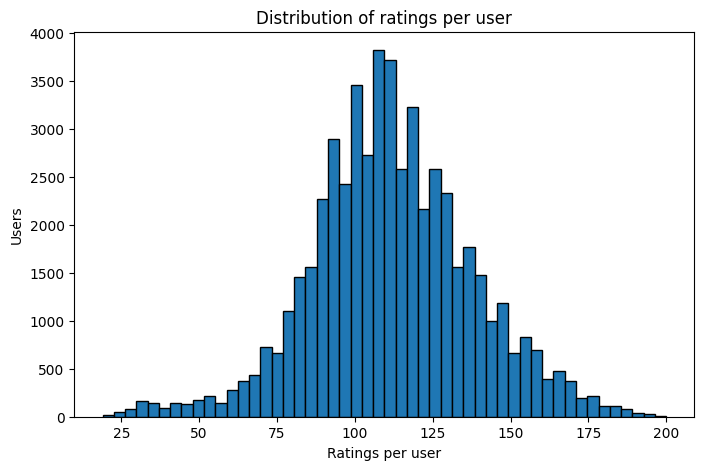

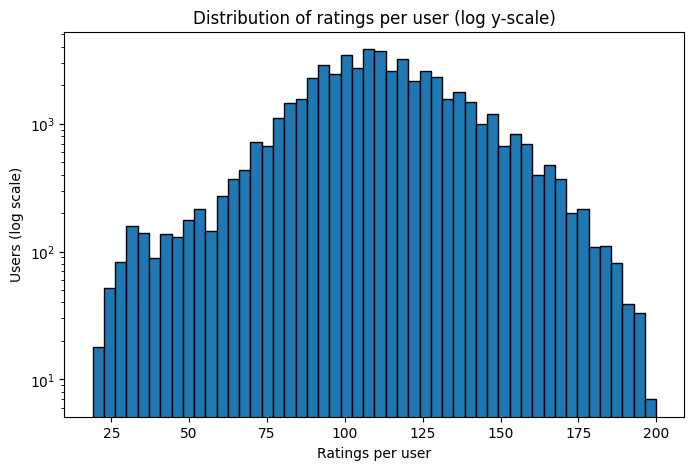

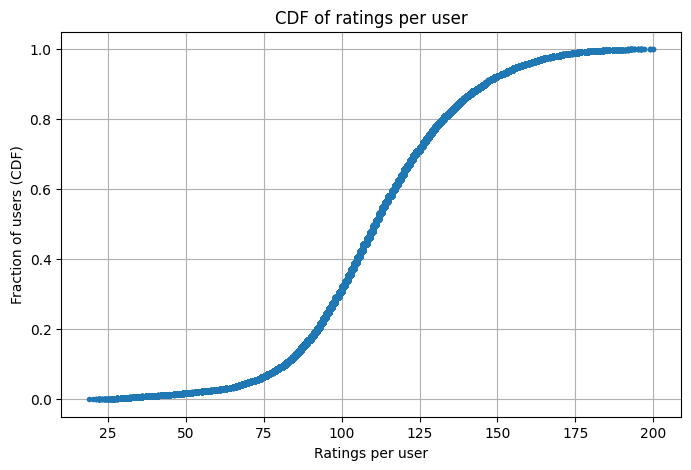

In [9]:
import matplotlib.pyplot as plt

user_counts = ratings.groupby("user_id").size()
book_counts = ratings.groupby("book_id").size()

# Histogram (users)
plt.figure(figsize=(8,5))
plt.hist(user_counts, bins=50, edgecolor='black')
plt.xlabel("Ratings per user")
plt.ylabel("Users")
plt.title("Distribution of ratings per user")
plt.show()

# Histogram (users, log y)
plt.figure(figsize=(8,5))
plt.hist(user_counts, bins=50, edgecolor='black', log=True)
plt.xlabel("Ratings per user")
plt.ylabel("Users (log scale)")
plt.title("Distribution of ratings per user (log y-scale)")
plt.show()

# CDF (users)
sorted_counts = np.sort(user_counts.values)
cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
plt.figure(figsize=(8,5))
plt.plot(sorted_counts, cdf, marker='.', linestyle='none')
plt.xlabel("Ratings per user")
plt.ylabel("Fraction of users (CDF)")
plt.title("CDF of ratings per user")
plt.grid(True)
plt.show()


### to_read

In [10]:
# Start from raw
to_read = dfs["to_read"].copy()

# 1) keep only rows with known books
valid_books = set(books_clean["book_id"])
before = len(to_read)
to_read = to_read[to_read["book_id"].isin(valid_books)]
print(f"filtered to known books: {before} -> {len(to_read)}")

# 2) drop duplicates
to_read = to_read.drop_duplicates(subset=["user_id", "book_id"]).reset_index(drop=True)
print("after dedup:", to_read.shape)

# 3) sanity stats
stats = {
    "rows": len(to_read),
    "unique_users": to_read["user_id"].nunique(),
    "unique_books": to_read["book_id"].nunique(),
    "median_wishlist_size": int(to_read.groupby("user_id").size().median()),
    "p95_wishlist_size": int(to_read.groupby("user_id").size().quantile(0.95)),
}
print(stats)
display(to_read.head(5))

# Save to dfs
dfs["to_read_clean"] = to_read


filtered to known books: 912705 -> 912705
after dedup: (912705, 2)
{'rows': 912705, 'unique_users': 48871, 'unique_books': 9986, 'median_wishlist_size': 14, 'p95_wishlist_size': 51}


,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


### tag + book_tags

{'unique_tags_final': 14235, 'rows_book_tags_clean': 857281, 'unique_books_with_tags': 10000}
p50: 77
p75: 308
p90: 1685
p95: 4854
p99: 51057


,count
tag_name,
fiction,3688819
fantasy,3548157
young-adult,1848306
classics,1756920
romance,1231926
ya,898334
mystery,872282
non-fiction,857901
historical-fiction,815421


,count
tag_name,
noir-fiction,16
nook-lendable,16
crewel-world,16
goodreads-choice-awards,16
read-non-mm,16
christian-read,16
end-of-world,16
1643-1715,16
walter-scott,16


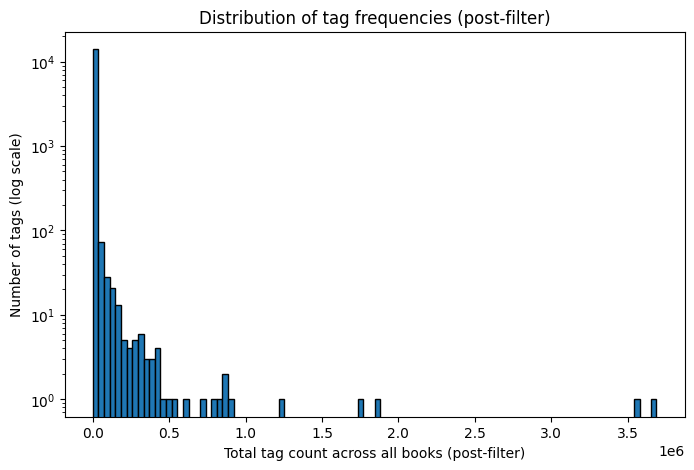

In [11]:
# Start from raw
tags_raw = dfs["tags"].copy()
book_tags_raw = dfs["book_tags"].copy()

# ---- Config (tune without changing code below) ----
RARE_TAG_MIN_TOTAL = 15   # drop tags with total count <= this
STOPLIST = {
    "to-read", "currently-reading", "favorites", "favorite", "my-books", "books-i-own",
    "owned", "kindle", "audible", "audio", "audiobook", "ebooks", "e-book", "ebook",
    "did-not-finish", "dnf", "abandoned",
    # year-shelf noise (extend if you see more)
    "2012","2013","2014","2015","2016","2017","2018","2019","2020","2021","2022","2023","2024","2025",
}

# ---- Helpers ----
def _clean_tag(s: pd.Series) -> pd.Series:
    # lowercase, remove punctuation except word-ish separators, collapse spaces
    s = s.str.lower()
    s = s.str.replace(r"[^a-z0-9\s\-\_\/\+]", " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s

# ---- Map tag_id → tag_name and normalize ----
tag_map = tags_raw.set_index("tag_id")["tag_name"]
bt = book_tags_raw.copy()
bt["tag_name"] = _clean_tag(bt["tag_id"].map(tag_map))

# Drop null tag names (if any mapping failed)
bt = bt[bt["tag_name"].notna()].copy()

# ---- Remove stoplist & non-positive counts ----
bt = bt[~bt["tag_name"].isin(STOPLIST)]
bt = bt[bt["count"] > 0]

# ---- Map goodreads_book_id → book_id (align to main key) ----
# books_clean has both columns; ensure unique mapping
key_map = books_clean[["book_id", "goodreads_book_id"]].dropna().drop_duplicates("goodreads_book_id")
bt = bt.merge(key_map, how="inner", on="goodreads_book_id")

# Keep only what we need going forward
bt = bt[["book_id", "tag_id", "tag_name", "count"]]

# ---- Drop ultra-rare tags by total frequency ----
tag_totals = bt.groupby("tag_name")["count"].sum()
keep_tags = tag_totals[tag_totals > RARE_TAG_MIN_TOTAL].index
bt = bt[bt["tag_name"].isin(keep_tags)].reset_index(drop=True)

# ---- Recompute totals & describe ----
tag_totals = (bt.groupby("tag_name")["count"]
              .sum()
              .sort_values(ascending=False))

print({
    "unique_tags_final": int(tag_totals.size),
    "rows_book_tags_clean": int(len(bt)),
    "unique_books_with_tags": int(bt["book_id"].nunique())
})

# Percentiles to sense-check threshold choices
counts = tag_totals.values
for p in [50, 75, 90, 95, 99]:
    print(f"p{p}: {int(np.percentile(counts, p))}")

display(tag_totals.head(20))
display(tag_totals.tail(20))

# ---- Plot (single readable histogram, log y-scale) ----
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(counts, bins=100, log=True, edgecolor="black")
plt.xlabel("Total tag count across all books (post-filter)")
plt.ylabel("Number of tags (log scale)")
plt.title("Distribution of tag frequencies (post-filter)")
plt.show()

# Persist for matrix building
book_tags_clean = bt
dfs["book_tags_clean"] = book_tags_clean
dfs["tag_totals"] = tag_totals


#### Count matrix

In [13]:
from scipy import sparse
import numpy as np
import pandas as pd
import os

# Expect: book_tags_clean with ['book_id','tag_name','count']
bt = book_tags_clean.copy()

# 0) sanity: drop nulls and non-positive counts (should be clean already)
bt = bt.dropna(subset=["book_id", "tag_name", "count"])
bt = bt[bt["count"] > 0]

# 1) aggregate duplicates just in case
bt = (bt.groupby(["book_id", "tag_name"], as_index=False)["count"]
        .sum())

# 2) build indices
book_index = pd.Index(books_clean["book_id"].dropna().astype(int).unique(), name="book_id")
tag_index  = pd.Index(sorted(bt["tag_name"].unique()), name="tag")

# maps
bid2row = pd.Series(range(len(book_index)), index=book_index)
tid2col = pd.Series(range(len(tag_index)), index=tag_index)

# keep only rows that appear in our index
bt = bt[bt["book_id"].isin(book_index) & bt["tag_name"].isin(tag_index)]

rows = bt["book_id"].map(bid2row).astype(np.int32).values
cols = bt["tag_name"].map(tid2col).astype(np.int32).values
vals = bt["count"].astype(np.float32).values

# 3) construct sparse matrix (CSR)
X_counts = sparse.coo_matrix(
    (vals, (rows, cols)),
    shape=(len(book_index), len(tag_index))
).tocsr()

print({
    "X_counts_shape": X_counts.shape,
    "nonzeros": int(X_counts.nnz),
    "density": float(round(X_counts.nnz / (X_counts.shape[0] * X_counts.shape[1] + 1e-9), 8)),
    "books_indexed": len(book_index),
    "tags_indexed": len(tag_index),
})

# quick peek: top tags for first 3 books that have any tags
def top_tags_for_book(row_idx: int, topn: int = 5):
    row = X_counts.getrow(row_idx).toarray().ravel()
    if row.sum() == 0:
        return []
    top_ids = row.argsort()[::-1][:topn]
    return [(tag_index[i], int(row[i])) for i in top_ids if row[i] > 0]

shown = 0
for i in range(min(50, X_counts.shape[0])):  # scan until we find books with tags
    t = top_tags_for_book(i, 5)
    if t:
        print(f"book_id={book_index[i]} → {t}")
        shown += 1
    if shown >= 3:
        break

# persist in memory for downstream steps
dfs["X_counts"] = X_counts
dfs["book_index"] = book_index
dfs["tag_index"] = tag_index

{'X_counts_shape': (10000, 14235), 'nonzeros': 854820, 'density': 0.00600506, 'books_indexed': 10000, 'tags_indexed': 14235}
book_id=1 → [('young-adult', 25968), ('fiction', 13819), ('dystopian', 12985), ('dystopia', 11065), ('fantasy', 10836)]
book_id=2 → [('fantasy', 47478), ('young-adult', 14984), ('fiction', 13239), ('harry-potter', 8559), ('ya', 5276)]
book_id=3 → [('young-adult', 16446), ('fantasy', 14288), ('vampires', 7438), ('ya', 6533), ('fiction', 6298)]


#### TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import os

# Inputs from previous cell
tfidf = TfidfTransformer(norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False)
X_tfidf = tfidf.fit_transform(dfs["X_counts"])

print({
    "X_tfidf_shape": X_tfidf.shape,
    "nonzeros": int(X_tfidf.nnz),
    "same_sparsity": bool(X_tfidf.nnz == dfs["X_counts"].nnz)
})

def top_tfidf_tags_for_book(row_idx: int, topn: int = 5):
    row = X_tfidf.getrow(row_idx)
    if row.nnz == 0:
        return []
    data = row.data
    idxs = row.indices
    order = np.argsort(data)[::-1][:topn]
    return [(dfs["tag_index"][idxs[i]], float(data[i])) for i in order]

# show top tf-idf tags for first 3 books with tags
shown = 0
for i in range(min(50, X_tfidf.shape[0])):
    items = top_tfidf_tags_for_book(i, 5)
    if items:
        print(f"book_id={dfs['book_index'][i]} (TF-IDF) → {items}")
        shown += 1
    if shown >= 3:
        break

# persist in memory
dfs["X_tfidf"] = X_tfidf
dfs["tfidf_model"] = tfidf

{'X_tfidf_shape': (10000, 14235), 'nonzeros': 854820, 'same_sparsity': True}
book_id=1 (TF-IDF) → [('young-adult', 0.5303540825843811), ('dystopian', 0.4719123840332031), ('dystopia', 0.4077669084072113), ('ya', 0.2479039579629898), ('hunger-games', 0.23256929218769073)]
book_id=2 (TF-IDF) → [('fantasy', 0.7623447179794312), ('harry-potter', 0.49783575534820557), ('young-adult', 0.2613339126110077), ('fiction', 0.12554770708084106), ('ya', 0.10320036113262177)]
book_id=3 (TF-IDF) → [('young-adult', 0.5396633744239807), ('vampires', 0.4556579291820526), ('fantasy', 0.43164336681365967), ('twilight', 0.2933608889579773), ('ya', 0.24042728543281555)]


## Save pre-split Artifacts

In [15]:
# Save pre-split artifacts to both /content and Drive

import os, json, shutil, glob
from scipy import sparse

LOCAL_OUT = "/content/preprocessed"
DRIVE_OUT = os.path.join(DATA_DIR, "preprocessed")

os.makedirs(LOCAL_OUT, exist_ok=True)
os.makedirs(DRIVE_OUT, exist_ok=True)

# 1) Tables
books_clean.to_csv(f"{LOCAL_OUT}/books_clean.csv", index=False)
ratings.to_csv(f"{LOCAL_OUT}/ratings_clean.csv", index=False)   # pre-split snapshot
to_read.to_csv(f"{LOCAL_OUT}/to_read_clean.csv", index=False)
book_tags_clean.to_csv(f"{LOCAL_OUT}/book_tags_clean.csv", index=False)

# 2) Indices / vocab
pd.Series(book_index, name="book_id").to_csv(f"{LOCAL_OUT}/book_index.csv", index=False)
pd.Series(tag_index, name="tag").to_csv(f"{LOCAL_OUT}/tag_vocab.csv", index=False)

# 3) Sparse matrices
sparse.save_npz(f"{LOCAL_OUT}/book_tag_counts.npz", X_counts)
sparse.save_npz(f"{LOCAL_OUT}/book_tag_tfidf.npz", X_tfidf)

# 4) Config snapshot for reproducibility
config = {
    "tag_min_total_count": 15,
    "stop_tags": sorted([
        "to-read","currently-reading","favorites","favorite","my-books","books-i-own",
        "owned","kindle","audible","audio","audiobook","ebooks","e-book","ebook",
        "did-not-finish","dnf","abandoned","2014","2015","2020","2021","2022","2023"
    ]),
    "tfidf": {"norm": "l2", "use_idf": True, "smooth_idf": True, "sublinear_tf": False},
}
with open(f"{LOCAL_OUT}/preprocessing_config.json", "w") as f:
    json.dump(config, f, indent=2)

# ---- copy everything to Drive for persistence
for src in glob.glob(f"{LOCAL_OUT}/*"):
    shutil.copy2(src, DRIVE_OUT)

print("✅ Saved artifacts")
print("Local:", LOCAL_OUT)
print("Drive:", DRIVE_OUT)
print("\nManifest:")
for p in sorted(glob.glob(f"{LOCAL_OUT}/*")):
    size_mb = os.path.getsize(p) / (1024*1024)
    print(f" - {os.path.basename(p):30s} {size_mb:6.2f} MB")


✅ Saved artifacts
Local: /content/preprocessed
Drive: /content/drive/MyDrive/BRS/preprocessed

Manifest:
 - book_index.csv                   0.05 MB
 - book_tag_counts.npz              2.06 MB
 - book_tag_tfidf.npz               3.98 MB
 - book_tags_clean.csv             20.21 MB
 - books_clean.csv                  2.64 MB
 - preprocessing_config.json        0.00 MB
 - ratings_clean.csv               68.79 MB
 - tag_vocab.csv                    0.18 MB
 - to_read_clean.csv                8.97 MB
